In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import exp
import os, time, copy

# FORMATANDO BLOWING
- Definindo os critérios de "inicio" e "fim" de sopro manualmente, isso foi feito individualmente em cada arquivo usando o critério de derivada para isso, mas a ideia é o modelo servir de modo geral

In [2]:
def isBlowing(start, end):
    global is_blowing

    if start:
        is_blowing = True

    if end:
        is_blowing = False

    return is_blowing


fileNum  = 13
filePath = f'test_{fileNum}.csv'
df = pd.read_csv(filePath)
df.head()

,time,pressure,mean,ratio,start_blow,stop_blow,blowing
0,2.1,36.01373,36.65847,-0.64474,False,False,False
1,2.2,35.93918,36.68786,-0.74868,False,False,False
2,2.3,35.87474,36.68101,-0.80627,False,False,False
3,2.4,35.81992,36.64651,-0.82659,False,False,False
4,2.5,35.77414,36.59187,-0.81773,False,False,False


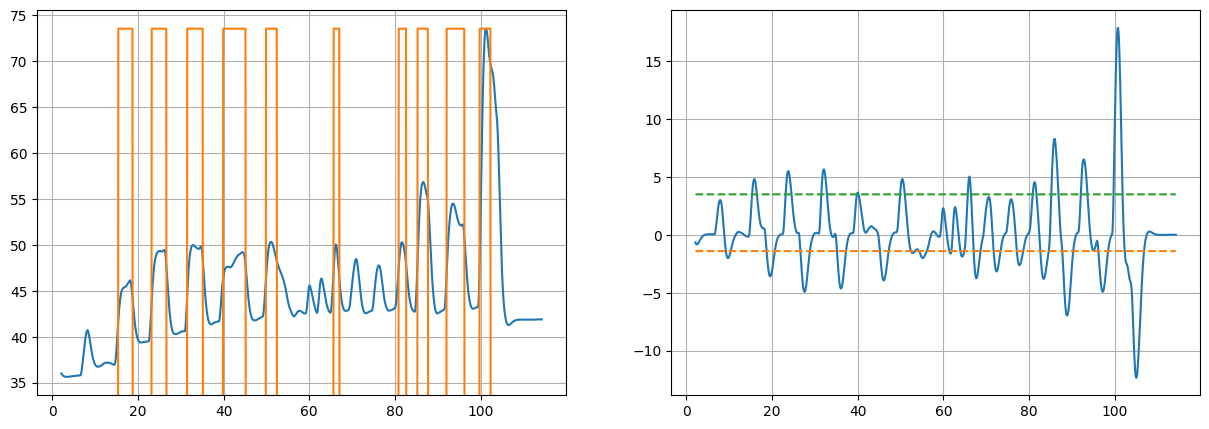

In [3]:
df = df.loc[df.time > 2.0]
is_blowing   = False
lower, upper = (-1.4, 3.5)

df['ratio'] = df['pressure'] - df['mean']
df['start_blow'] = df.ratio > upper
df['stop_blow']  = df.ratio < lower
df['blowing']    = df.apply(lambda row: isBlowing(row.start_blow, row.stop_blow), axis=1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(df.time, df.pressure)
plt.plot(df.time, df.blowing*df.pressure.max())
plt.ylim(df.pressure.min()-2, df.pressure.max()+2), plt.grid()

plt.subplot(1, 2, 2)
plt.plot(df.time, df.ratio)
plt.plot(df.time, lower * np.ones_like(df.time), '--')
plt.plot(df.time, upper * np.ones_like(df.time), '--')
plt.grid()
df.to_csv(filePath, index=None)

# VERIFICANDO TABELAS

In [4]:
files = [file for file in os.listdir(None) if '.csv' in file]
print(files)

['test_1.csv', 'test_10.csv', 'test_11.csv', 'test_12.csv', 'test_13.csv', 'test_2.csv', 'test_3.csv', 'test_4.csv', 'test_5.csv', 'test_6.csv', 'test_7.csv', 'test_8.csv', 'test_9.csv']


In [5]:
def getTables(files):
    tables = {}

    for filePath in files:
        tables[filePath] = pd.read_csv(filePath)

    return tables


tables = getTables(files)
tables[files[0]]

,time,pressure,mean,ratio,start_blow,stop_blow,blowing
0,2.1,40.10467,40.12988,-0.02521,False,False,False
1,2.2,40.10160,40.12774,-0.02614,False,False,False
2,2.3,40.09878,40.12553,-0.02675,False,False,False
3,2.4,40.09624,40.12325,-0.02701,False,False,False
4,2.5,40.09407,40.12092,-0.02685,False,False,False
...,...,...,...,...,...,...,...
540,56.1,52.16488,53.39425,-1.22937,False,True,False
541,56.2,52.08163,53.30609,-1.22446,False,True,False
542,56.3,52.00801,53.20163,-1.19362,False,True,False
543,56.4,51.94256,53.08652,-1.14396,False,True,False


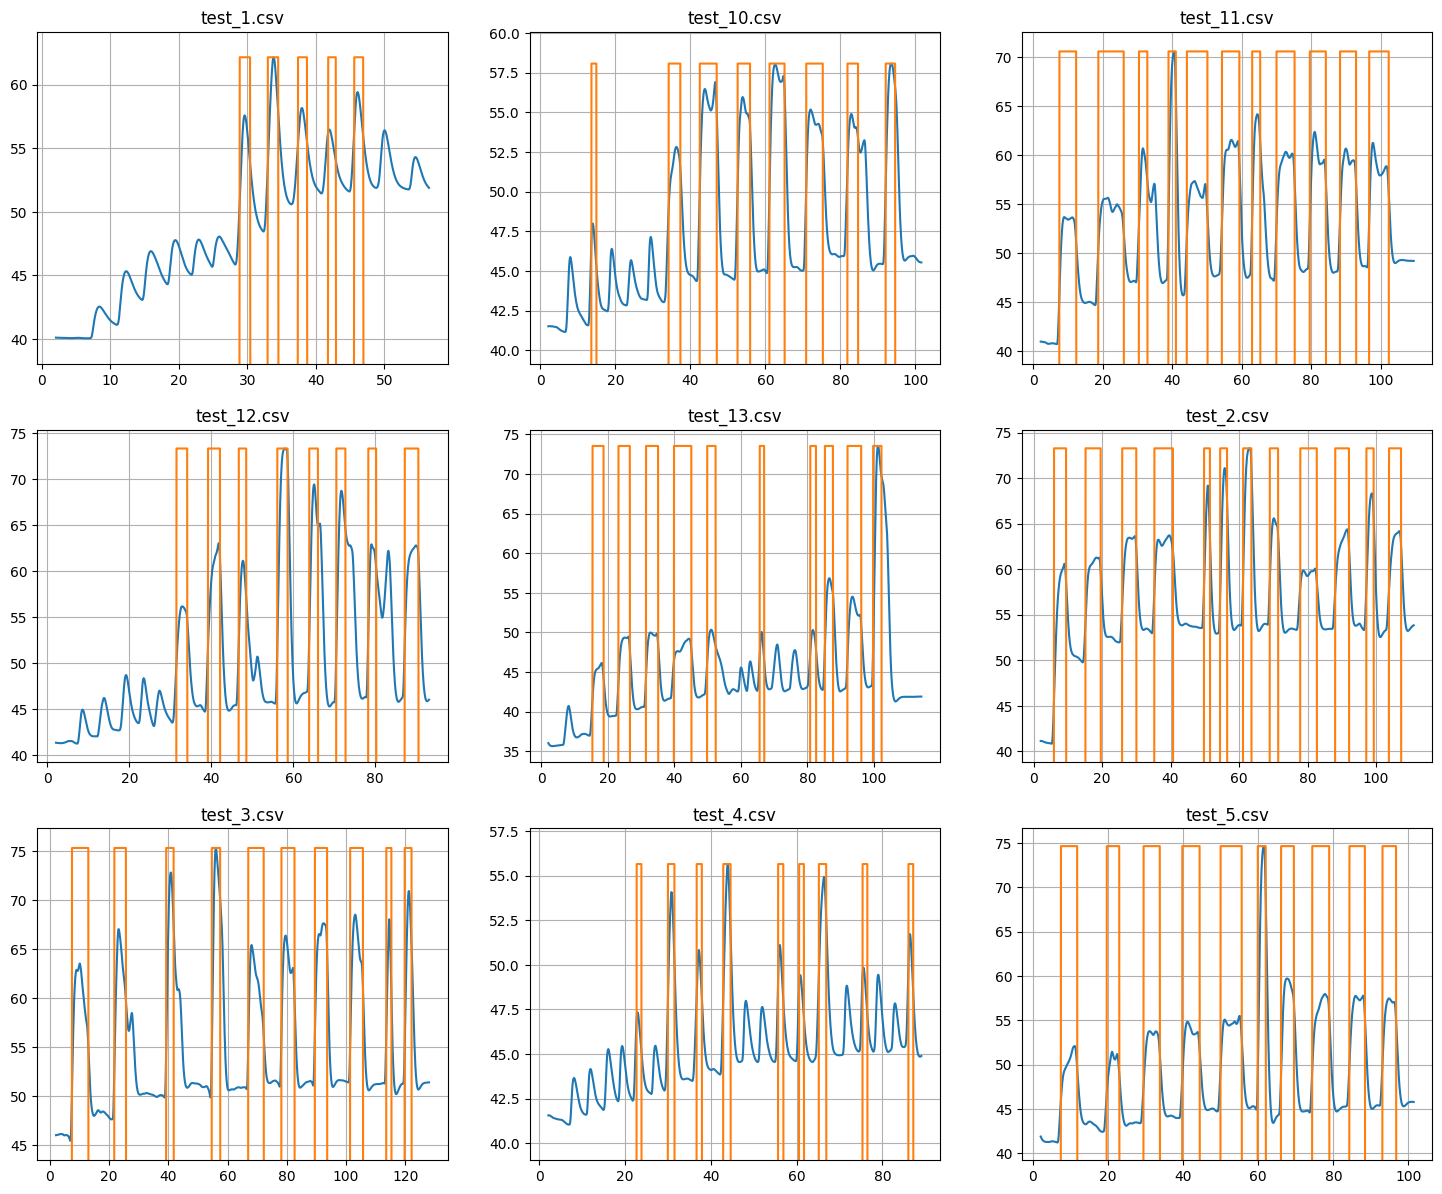

In [6]:
def plotTables(tables, limit=None):
    numRows = len(tables.values()) // 3 + 1
    plt.figure(figsize=(18, 5*numRows))

    for i, name in enumerate(tables.keys()):
        table = tables[name]
        plt.subplot(numRows, 3, i+1)
        plt.plot(table.time, table.pressure)
        plt.plot(table.time, table.blowing*table.pressure.max())
        plt.ylim(table.pressure.min()-2, table.pressure.max()+2)
        plt.grid(), plt.title(name)

        if limit is not None and i == limit - 1:
            break
    
    plt.show()


plotTables(tables, limit=9)

# JUNTANDO TABELAS
- Todos os arquivos agora serão juntados em 1 só, para isso, o tempo terá que iniciar (ser somado) partir do último valor do arquivo anterior (para ficar contínuo)

size: 12466


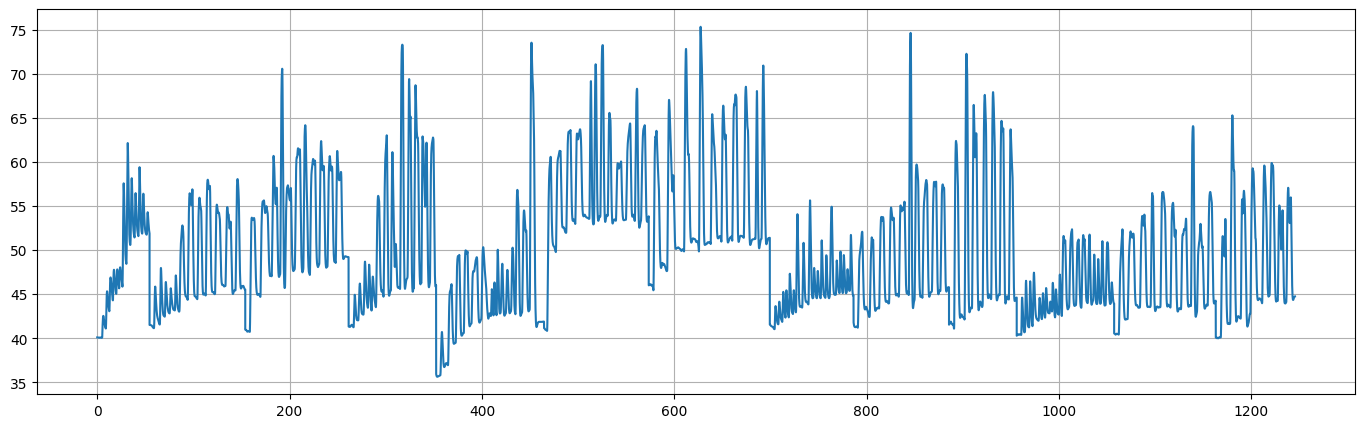

In [7]:
def joinTables(tables):
    df = pd.DataFrame()

    for table in tables.values():
        table['time'] = table.time - table.time.values[0]
        t0 = 0 if len(df) == 0 else df.time.values[-1]

        table['time'] = table.time + t0
        df = pd.concat([df, table])

    return df


df = joinTables(tables)
print('size:', len(df))
plt.figure(figsize=(17, 5))
plt.plot(df.time, df.pressure)
plt.grid()

In [8]:
def getChance(percentage=30):
    return np.random.rand() < (percentage / 100)

getChance(60)

False

In [9]:
tables[f'test_{(1 % 5) + 1}.csv']

,time,pressure,mean,ratio,start_blow,stop_blow,blowing
0,464.5,41.14650,40.96979,0.17671,False,False,False
1,464.6,41.14649,40.98488,0.16161,False,False,False
2,464.7,41.14470,40.99992,0.14478,False,False,False
3,464.8,41.14058,41.01476,0.12582,False,False,False
4,464.9,41.13365,41.02927,0.10438,False,False,False
...,...,...,...,...,...,...,...
1085,573.0,53.73856,53.45668,0.28188,False,False,False
1086,573.1,53.76936,53.45644,0.31292,False,False,False
1087,573.2,53.79695,53.46730,0.32965,False,False,False
1088,573.3,53.82152,53.48660,0.33492,False,False,False


In [10]:
for i in range(300):
    tableIndex = (i % len(tables)) + 1
    oldTableName = f'test_{tableIndex}.csv'
    newTableName = f'test_{len(tables)+1}.csv'
    
    oldTable = tables[oldTableName]
    tables[newTableName] = oldTable.copy()

len(tables)

313

test_1.csv (modo 0): m = 0.99 | s = -22.84
test_10.csv (modo 1): m = 1.01 | s = -0.15
test_11.csv (modo 2): m = 0.82 | s = 362.59
test_12.csv (modo 0): m = 1.15 | s = -25.80
test_13.csv (modo 2): m = 0.95 | s = 387.70
test_2.csv (modo 0): m = 1.10 | s = -32.03
test_3.csv (modo 2): m = 0.82 | s = 85.03
test_4.csv (modo 2): m = 1.01 | s = 162.94
test_5.csv (modo 2): m = 1.09 | s = 142.15
test_6.csv (modo 2): m = 0.93 | s = 370.18
test_7.csv (modo 1): m = 0.96 | s = 3.52
test_8.csv (modo 2): m = 0.81 | s = 195.23
test_9.csv (modo 2): m = 0.95 | s = 366.20
test_14.csv (modo 2): m = 0.76 | s = 94.13
test_15.csv (modo 2): m = 0.86 | s = 26.85
test_16.csv (modo 1): m = 1.01 | s = -9.87
test_17.csv (modo 2): m = 0.76 | s = 28.02
test_18.csv (modo 1): m = 1.02 | s = -7.52
test_19.csv (modo 1): m = 1.03 | s = 3.49
test_20.csv (modo 1): m = 0.96 | s = 5.93
test_21.csv (modo 0): m = 0.90 | s = -31.06
test_22.csv (modo 1): m = 0.97 | s = -3.32
test_23.csv (modo 2): m = 0.89 | s = 369.49
test_24.csv

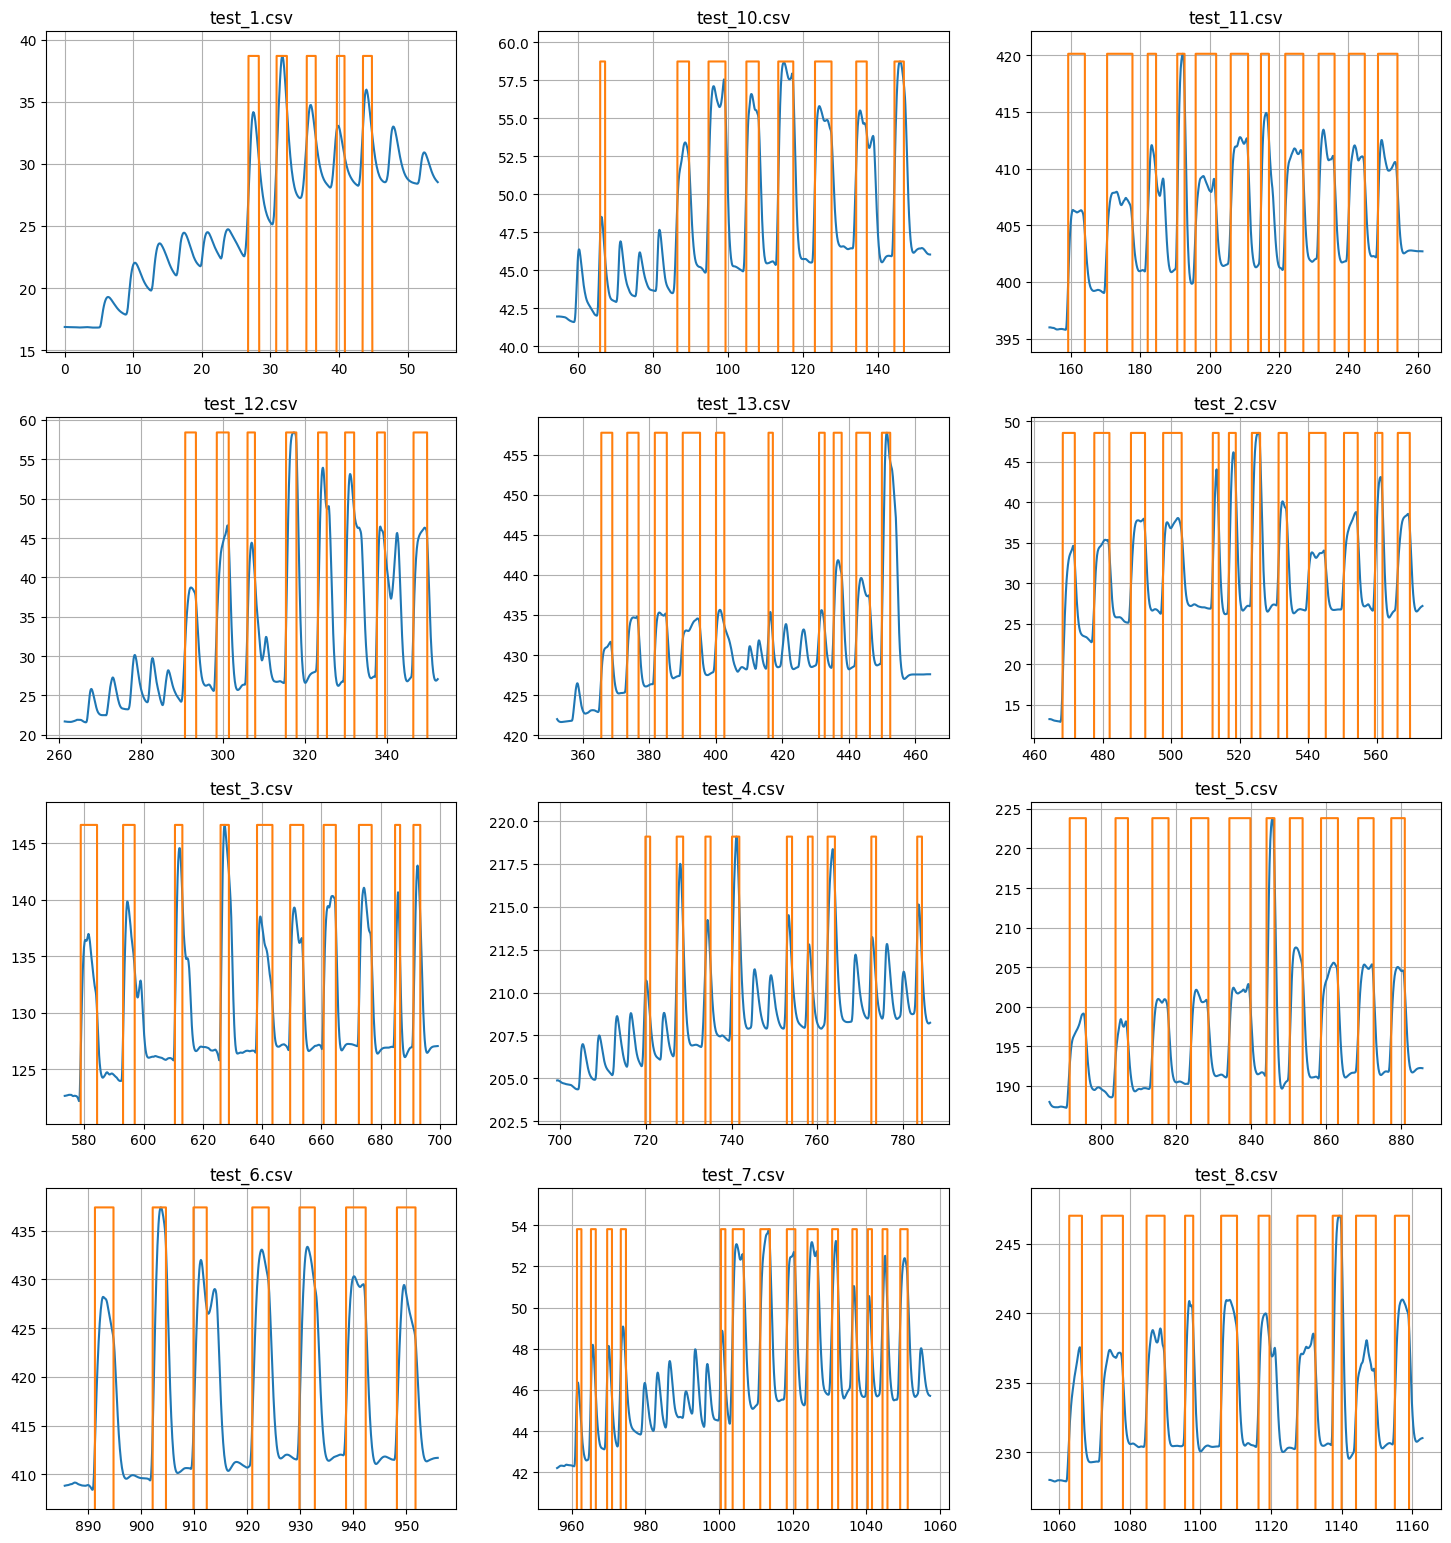

In [11]:
def normalizeTables(df):
    dataset = copy.deepcopy(df)

    for name, table in dataset.items():
        if getChance(30):
            mode = 0
            multiplyer = np.random.uniform(0.75, 1.15)
            somador = np.random.uniform(-35, -15)
        elif getChance(40):
            mode = 1
            multiplyer = np.random.uniform(0.95, 1.05)
            somador = np.random.uniform(-10, 10)
        else:
            mode = 2
            multiplyer = np.random.uniform(0.75, 1.15)
            somador = np.random.uniform(15, 400)
        
        print(f'{name} (modo {mode}): m = {multiplyer:.2f} | s = {somador:.2f}')
        table['pressure'] = (table['pressure'] * multiplyer) + somador
        table['mean']     = (table['mean'] * multiplyer) + somador

    return dataset


normalized = normalizeTables(tables)
plotTables(normalized, limit=12)

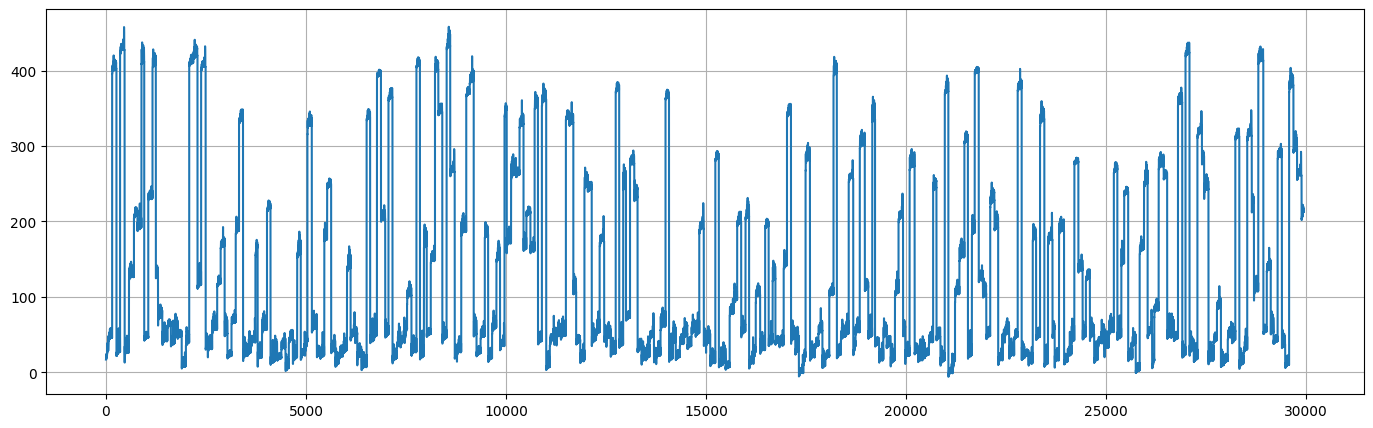

In [12]:
df = joinTables(normalized)
df.to_csv('../DataBase.csv', index=None)
plt.figure(figsize=(17, 5))
plt.plot(df.time, df.pressure)
plt.grid()

# OBTENDO A VARIAVEL DESEJADA
Os valores de início e fim de sopro são os pontos discretizados ao longo do gráfico, o objetivo do modelo é encontrar o momento que iniciou o sopro, e o momento que não há mais sopro

test_1.csv


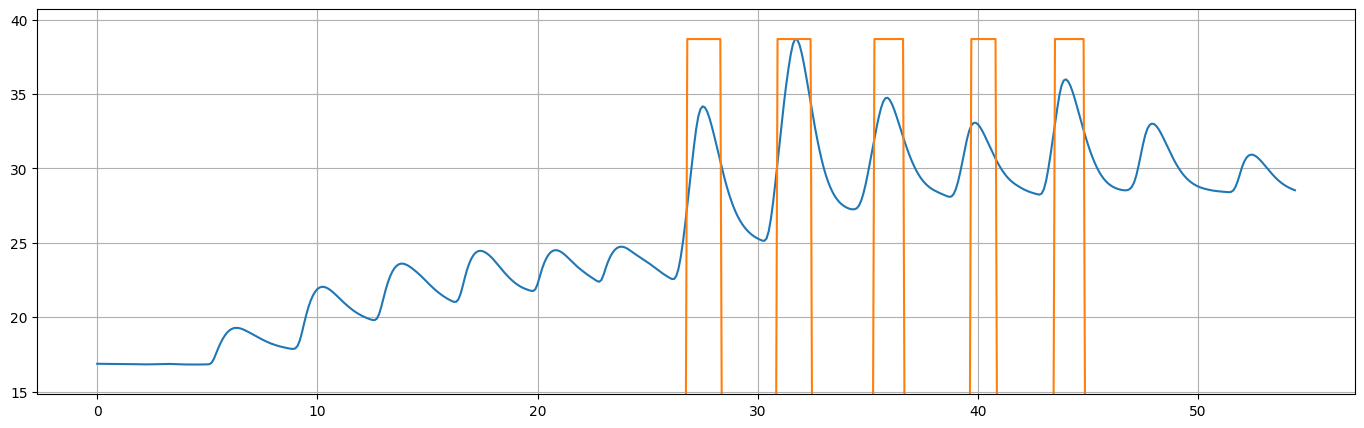

test_10.csv


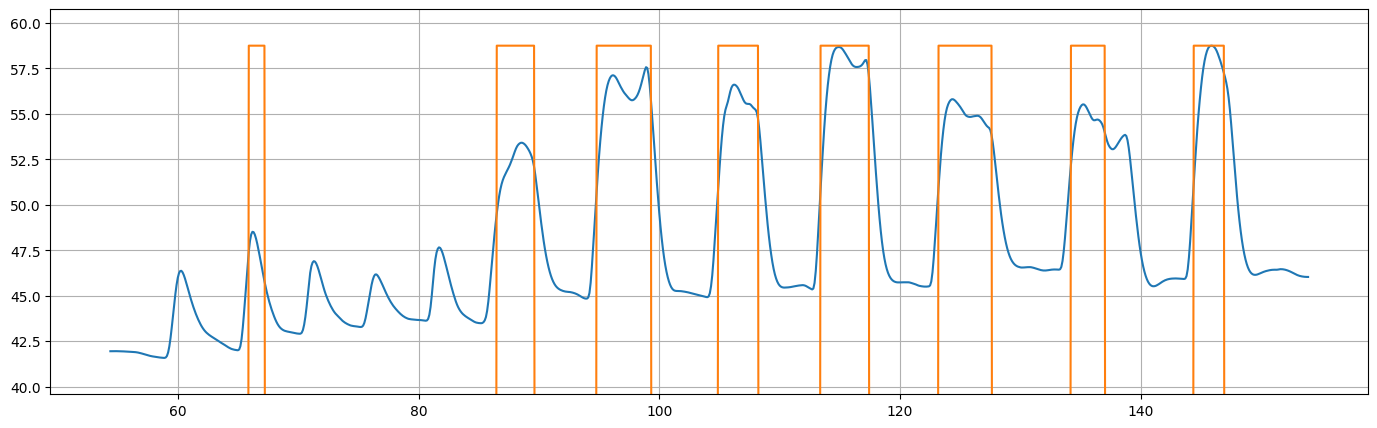

test_11.csv


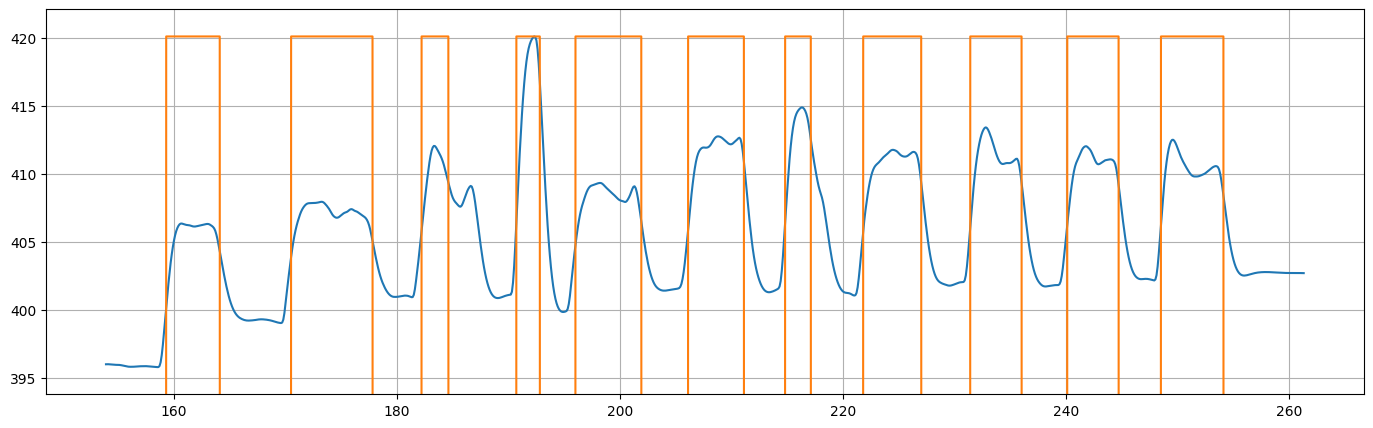

test_12.csv


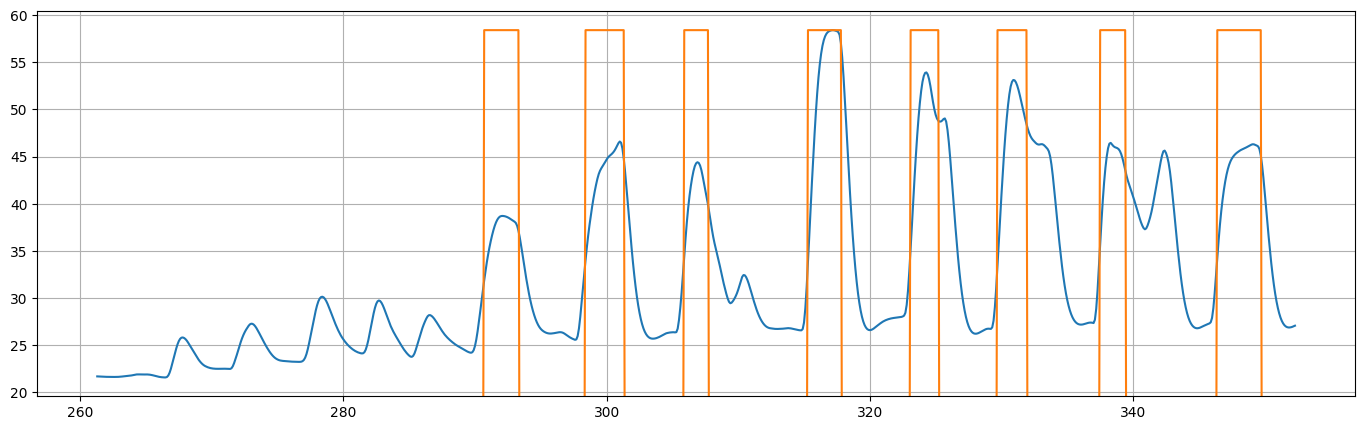

test_13.csv


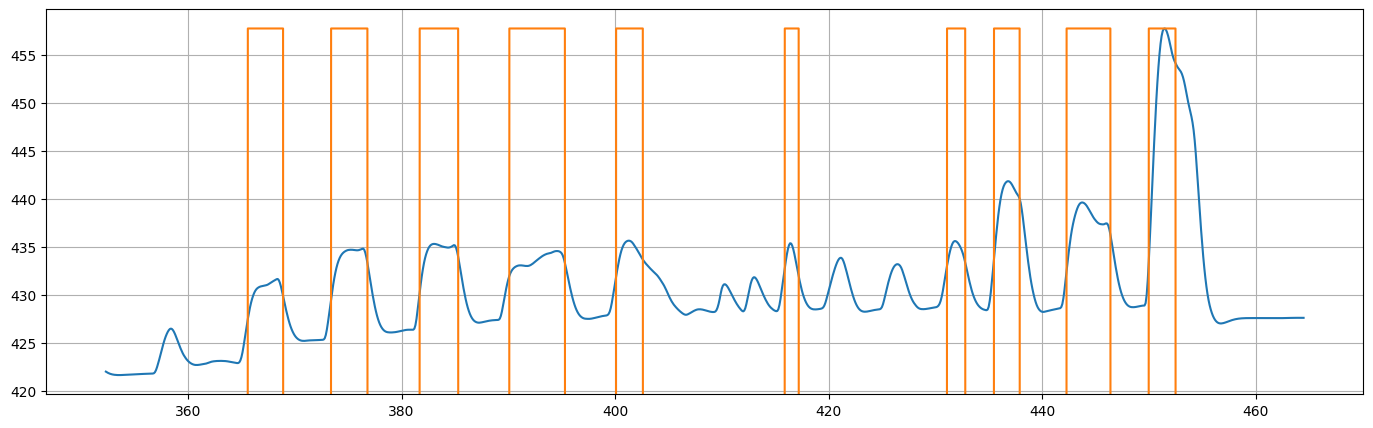

test_2.csv


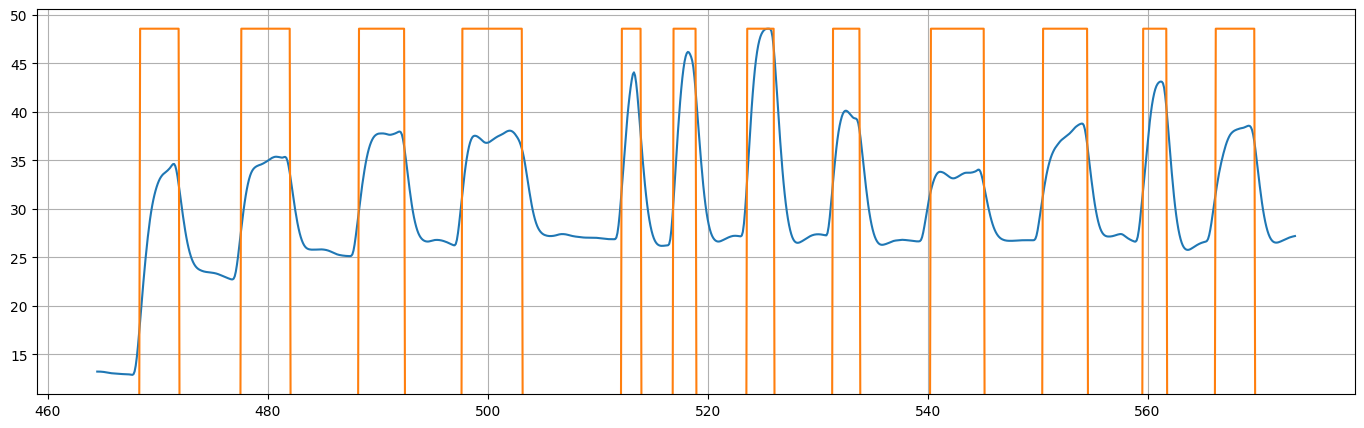

test_3.csv


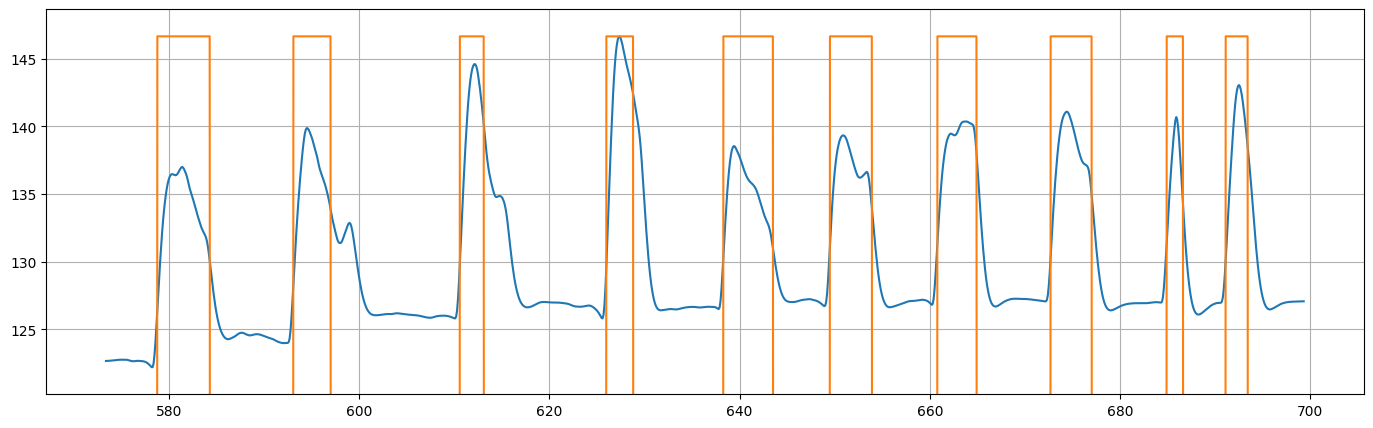

test_4.csv


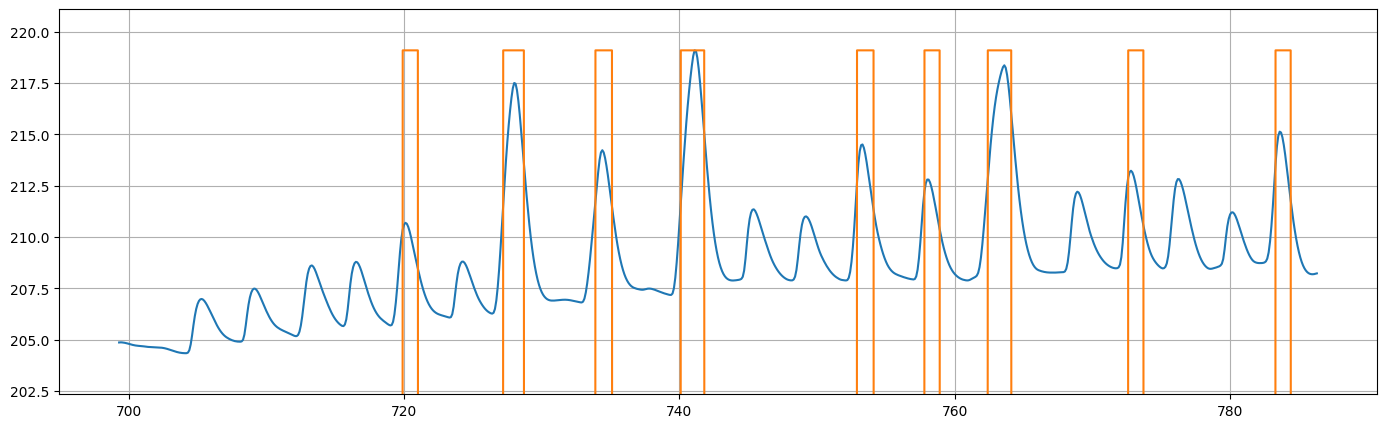

test_5.csv


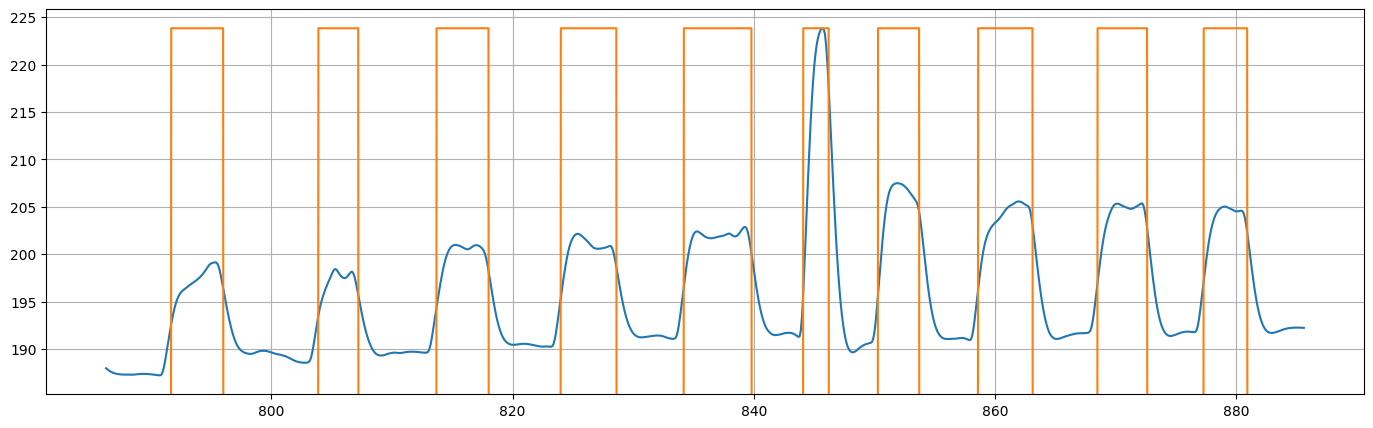

test_6.csv


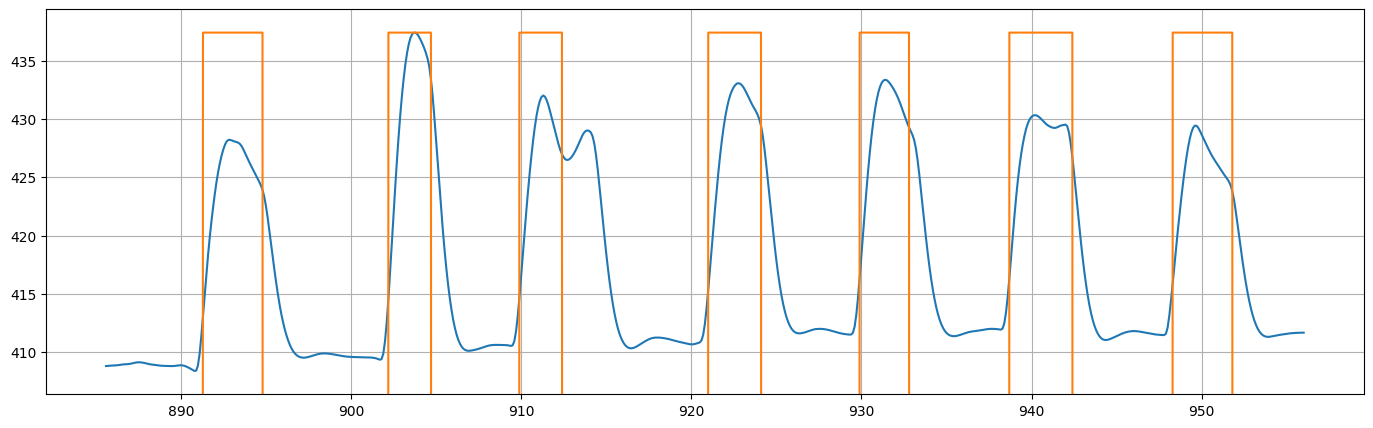

test_7.csv


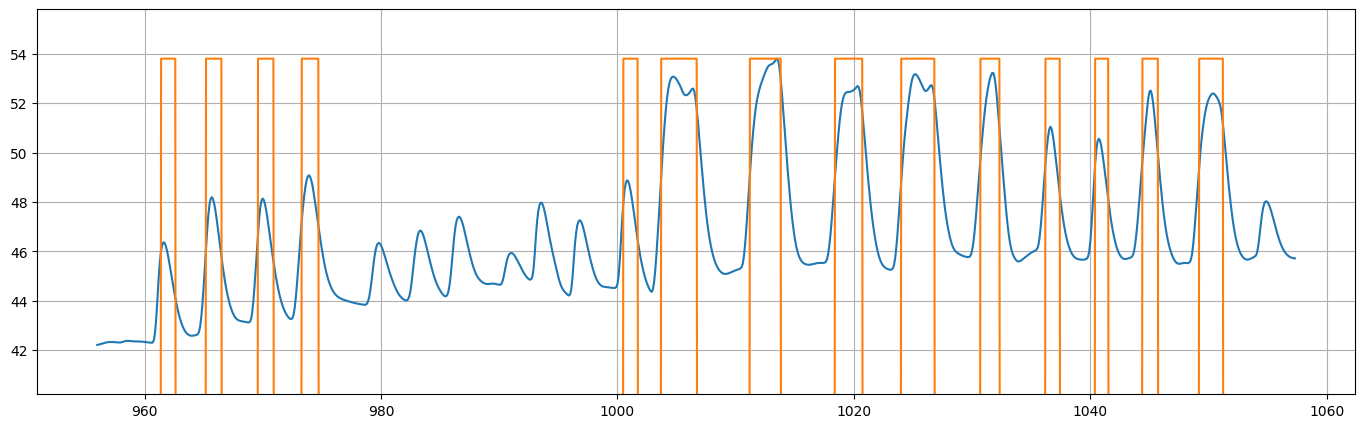

test_8.csv


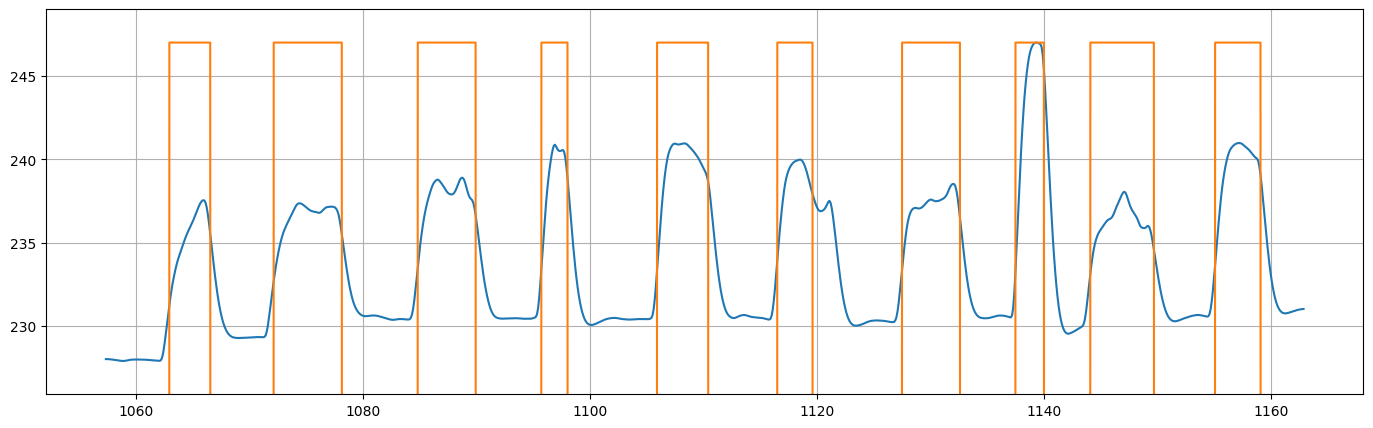

test_9.csv


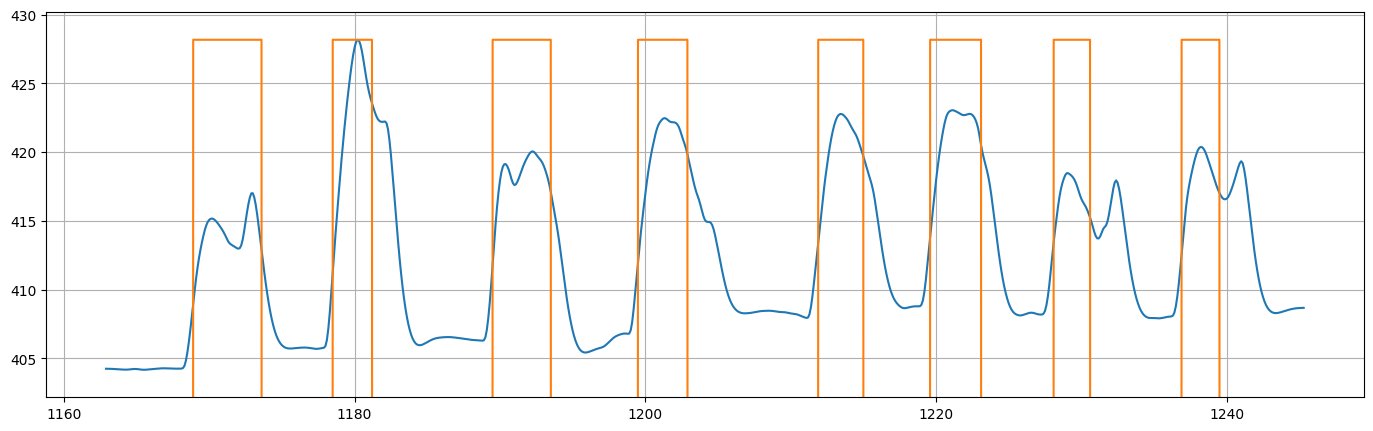

In [13]:
for i, (name, df) in enumerate(normalized.items()):
    plt.figure(figsize=(17, 5))
    plt.plot(df.time, df.pressure)
    plt.plot(df.time, df.blowing * df.pressure.max())
    plt.ylim(df.pressure.min()-2, df.pressure.max()+2)
    print(name), plt.grid(), plt.show()

    if i == len(files) - 1:
        break